In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam


In [2]:
 #Load your dataset
df = pd.read_csv('creditcard.csv')  # Uncomment and modify to load data

df = pd.DataFrame({
    'Time': np.random.uniform(0,100000,1000),
    'Amount': np.random.uniform(0,1000,1000),
    'feature1': np.random.normal(0,1,1000),
    'feature2': np.random.normal(0,1,1000),
    'target': np.random.choice([0,1], 1000, p=[0.95,0.05])
})

In [3]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

In [4]:
# Standardize only 'Amount' and 'Time' columns
scaler = StandardScaler()
X[['Amount', 'Time']] = scaler.fit_transform(X[['Amount', 'Time']])


In [5]:
# Split the data into normal (target=0) and fraud (target=1)
X_normal = X[y == 0]
X_fraud = X[y == 1]

In [6]:
# Use only normal data for training the autoencoder
X_train, X_test_normal = train_test_split(X_normal, test_size=0.2, random_state=42)

In [7]:
# Create test set combining normal and fraud data
X_test = pd.concat([X_test_normal, X_fraud])
y_test = np.concatenate([np.zeros(len(X_test_normal)), np.ones(len(X_fraud))])

In [8]:
# Define Autoencoder architecture
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(14, activation='relu')(input_layer)
encoder = Dense(7, activation='relu')(encoder)
bottleneck = Dense(3, activation='relu')(encoder)
decoder = Dense(7, activation='relu')(bottleneck)
decoder = Dense(14, activation='relu')(decoder)
output_layer = Dense(input_dim, activation='linear')(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


In [9]:
# Train the autoencoder
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_normal, X_test_normal),
    shuffle=True
)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.9986 - val_loss: 0.9841
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9838 - val_loss: 0.9623
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9573 - val_loss: 0.9241
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9187 - val_loss: 0.8768
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8856 - val_loss: 0.8459
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8671 - val_loss: 0.8324
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8571 - val_loss: 0.8240
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8495 - val_loss: 0.8167
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8425 - val_loss: 0.8102
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8364 - val_loss: 0.8044
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8309 - val_loss: 0.7991
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8257 - val_l

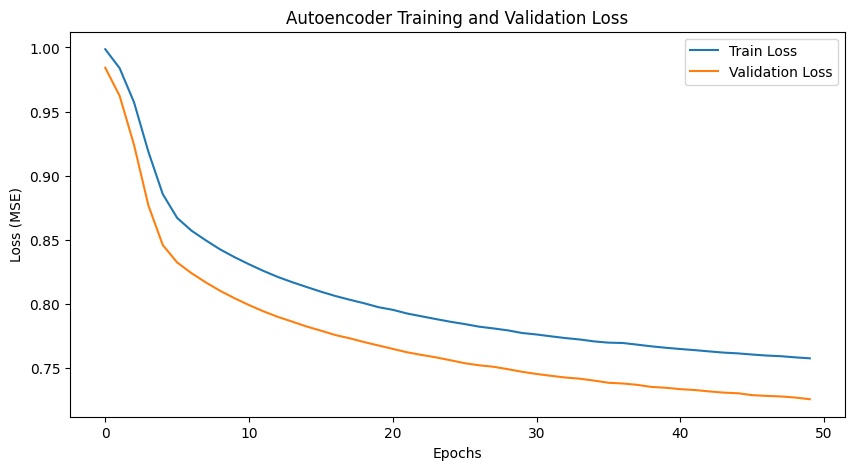

In [10]:
# Plot training and validation loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Autoencoder Training and Validation Loss')
plt.show()

In [11]:
# Calculate reconstruction error on test set
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


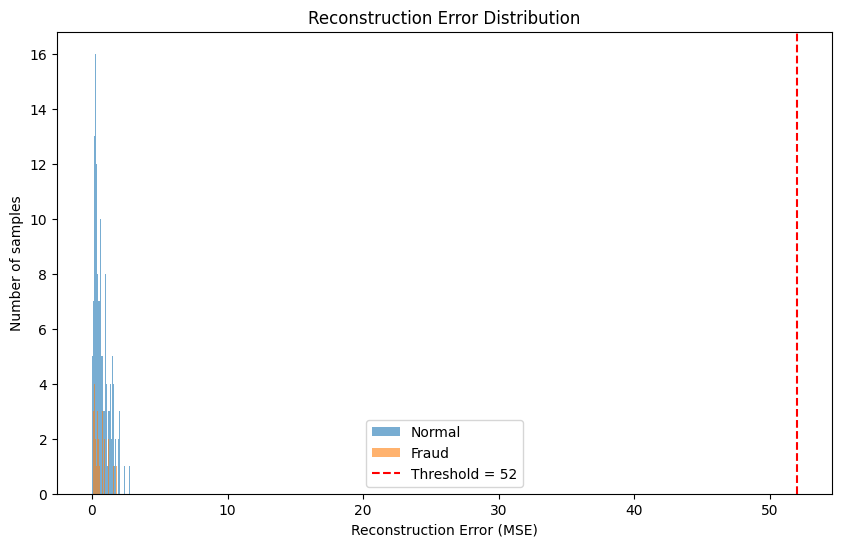

In [12]:

# Plot reconstruction error and threshold
plt.figure(figsize=(10,6))
plt.hist(mse[y_test == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(mse[y_test == 1], bins=50, alpha=0.6, label='Fraud')
plt.axvline(x=52, color='r', linestyle='--', label='Threshold = 52')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Number of samples')
plt.legend()
plt.title('Reconstruction Error Distribution')
plt.show()

In [13]:
# Detect anomalies based on threshold
threshold = 52
y_pred = (mse > threshold).astype(int)

In [14]:
# Evaluate results (optional - requires sklearn)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      1.00      0.90       192
         1.0       0.00      0.00      0.00        44

    accuracy                           0.81       236
   macro avg       0.41      0.50      0.45       236
weighted avg       0.66      0.81      0.73       236



c:\Users\racha\anaconda3\envs\pythonProject3\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\racha\anaconda3\envs\pythonProject3\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\racha\anaconda3\envs\pythonProject3\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi